# Animation of VI and PI for LQR

This is an animation of VI and PI algorithms applied to scalar linear quadratic problems.

Copyright @ Yuchao Li, Dimitri P. Bertsekas

In [6]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from google.colab import files  # For downloading the file in Colab

# ---------------------------------
# System and Problem Parameters
# ---------------------------------
A = 1.0       # System dynamics: x_{t+1} = A*x_t + B*u_t
B = 1.0
Q = 0.5       # State cost weight
R = 2.0       # Control cost weight
gamma = 1.0  # Discount factor

def riccati_update(K):
    """
    Returns the updated quadratic coefficient according to:
        F(K) = Q + γ A^2 K - (γ A B K)^2 / (R + γ B^2 K)
    """
    return Q + gamma*(A**2)*K - (gamma*A*B*K)**2 / (R + gamma*(B**2)*K)

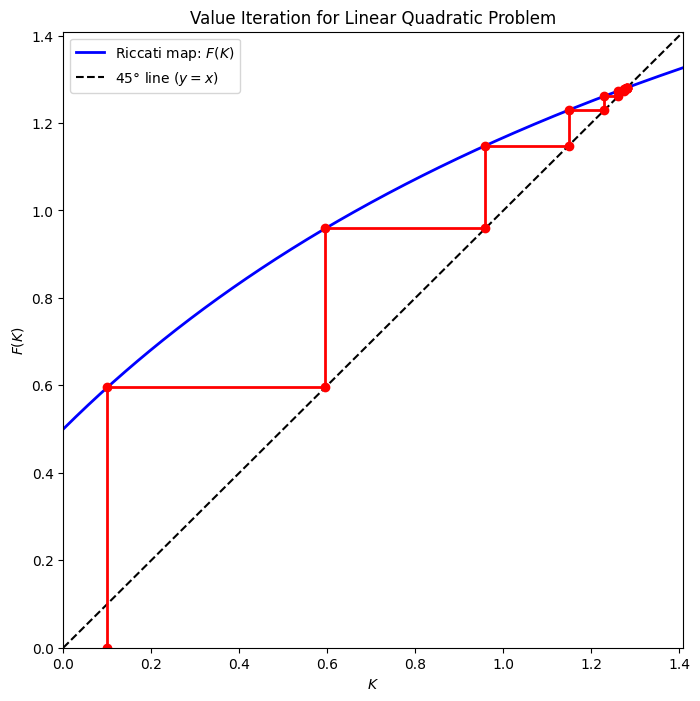

In [7]:
# ---------------------------------
# Compute the Fixed-Point Iterates
# ---------------------------------
# Choose an initial guess for K.
K0 = 0.1
num_iter = 10  # Number of VI iterations

# Compute the sequence of K values via the Riccati update:
K_seq = [K0]
for i in range(num_iter):
    K_next = riccati_update(K_seq[-1])
    K_seq.append(K_next)

# ---------------------------------
# Build the Cobweb (Staircase) Points
# ---------------------------------
# The cobweb diagram is constructed as follows:
#   - Start at (K0, 0)
#   - Draw vertical to (K0, F(K0))
#   - Then horizontal to (F(K0), F(K0))  [i.e., onto the 45° line]
#   - Then vertical from (F(K0), F(K0)) to (F(K0), F(F(K0)))
#   - Then horizontal to (F(F(K0)), F(F(K0))) ... etc.
cobweb_points = []
cobweb_points.append((K_seq[0], 0))  # starting point on x-axis

for i in range(len(K_seq)-1):
    # Vertical move: from (K_i, current level) to (K_i, F(K_i)) = (K_i, K_{i+1})
    cobweb_points.append((K_seq[i], K_seq[i+1]))
    # Horizontal move: from (K_i, K_{i+1}) to (K_{i+1}, K_{i+1})
    cobweb_points.append((K_seq[i+1], K_seq[i+1]))

# Separate the cobweb points into x and y lists:
x_cob = [pt[0] for pt in cobweb_points]
y_cob = [pt[1] for pt in cobweb_points]

# ---------------------------------
# Prepare the Background Plot
# ---------------------------------
# Define a range for K that covers our iterates.
p_min = 0
p_max = max(K_seq[0], max(K_seq)) * 1.1
p_vals = np.linspace(p_min, p_max, 400)
f_vals = riccati_update(p_vals)

# Create the plot
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(p_vals, f_vals, 'b-', lw=2, label='Riccati map: $F(K)$')
ax.plot(p_vals, p_vals, 'k--', lw=1.5, label='45° line ($y=x$)')

ax.set_xlabel('$K$')
ax.set_ylabel('$F(K)$')
ax.set_title('Value Iteration for Linear Quadratic Problem')
ax.legend()
ax.set_xlim(p_min, p_max)
ax.set_ylim(p_min, p_max)

# Prepare a line object for the cobweb (staircase) construction:
cobweb_line, = ax.plot([], [], 'r-', lw=2, marker='o')

# ---------------------------------
# Animation Functions
# ---------------------------------
def init():
    """Initialize the cobweb line."""
    cobweb_line.set_data([], [])
    return cobweb_line,

def animate(i):
    """
    Update function for the animation.
    In frame i, draw the cobweb (staircase) using the points up to index i.
    """
    cobweb_line.set_data(x_cob[:i+1], y_cob[:i+1])
    return cobweb_line,

# Create the animation: one frame per cobweb point
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=len(x_cob), interval=500, blit=True, repeat=False)

# ---------------------------------
# Save and Download the Animation as an MP4 file
# ---------------------------------
# Save the animation as an MP4 file (requires ffmpeg, which is pre-installed in Colab)
# anim.save('animation.mp4', writer='ffmpeg', fps=2)

# Download the MP4 file
# files.download('animation.mp4')

# (Optional) Also display the animation inline
# HTML(anim.to_jshtml())
display(HTML(anim.to_html5_video()))

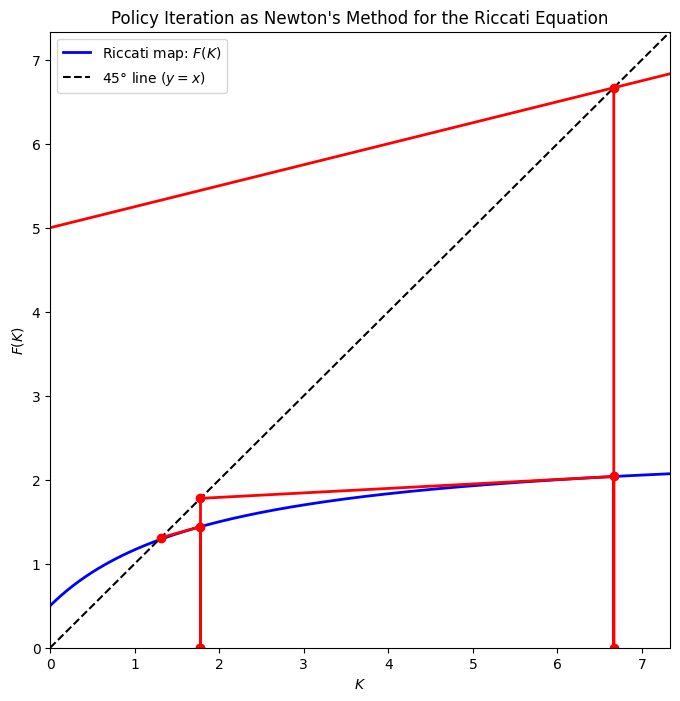

In [8]:
# ---------------------------------
# Define functions
# ---------------------------------


def riccati_update_deriv(K):
    """
    Computes the derivative of F(K) with respect to K.

    Write F(K) in compact form as:
       F(K) = Q + α K - β K²/(R + δ K)
    with α = γA², β = (γAB)², δ = γB².
    Then:
       F'(K) = α - β*(2R*K + δ K²)/(R+δK)².
    """
    num = (gamma*A*B)**2
    return gamma*A**2 - num*(2*R*K + gamma*B**2*K**2) / (R + gamma*B**2*K)**2

def newton_update(K):
    """
    Interprets policy iteration as Newton's method for solving F(K)=K.
    The tangent (linearization) of F at K is:
         L(K') = F(K) + F'(K)(K' - K)
    Setting L(K') = K' (i.e. y = x) and solving for K' gives:
         K' = K + (F(K) - K) / (1 - F'(K)).
    """
    F_val = riccati_update(K)
    F_deriv = riccati_update_deriv(K)
    return K + (F_val - K) / (1 - F_deriv)


# ---------------------------------
# Phase 0: Compute the Intersection Point for the Initial Policy
# ---------------------------------
# Under the policy u=-Lx the cost line is:
#    y = (A+B*L)^2 * K + (Q + R*L^2)
# Its intersection with y = K occurs at
#    K0 = (Q + R*L^2) / (1 - (A+B*L)^2).
# Choose a stabilizing gain L so that |A+B*L| < 1.
L = -1.5   # For example, A+B*L = 1.0 + 1.0*(-0.2) = 0.8 < 1.
K0 = (Q + R*(L**2)) / (1 - (A+B*L)**2)

# ---------------------------------
# Compute the Newton/Policy Iteration Sequence
# ---------------------------------
# Use K0 as the starting value.
num_iter = 2  # Number of Newton updates
newton_seq = [K0]
for i in range(num_iter):
    newton_seq.append(newton_update(newton_seq[-1]))

# ---------------------------------
# Build the Cobweb (Staircase) Points
# ---------------------------------
# For each Newton update, build the cobweb with:
#  1. Vertical move: from (K_i, 0) to (K_i, F(K_i))
#  2. Diagonal move: from (K_i, F(K_i)) to (K_{i+1}, K_{i+1})
#  3. Horizontal drop: from (K_{i+1}, K_{i+1}) to (K_{i+1}, 0)
cobweb_points = [(K0,K0)]
for i in range(len(newton_seq)-1):
    cobweb_points.append((newton_seq[i], 0))
    cobweb_points.append((newton_seq[i], riccati_update(newton_seq[i])))
    cobweb_points.append((newton_seq[i+1], newton_seq[i+1]))
    cobweb_points.append((newton_seq[i+1], 0))

# Separate the cobweb points into x and y coordinate lists.
x_cob = [pt[0] for pt in cobweb_points]
y_cob = [pt[1] for pt in cobweb_points]

# ---------------------------------
# Prepare the Background Plot
# ---------------------------------
p_min = 0
p_max = max(newton_seq)*1.1
p_vals = np.linspace(p_min, p_max, 400)
f_vals = riccati_update(p_vals)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(p_vals, f_vals, 'b-', lw=2, label='Riccati map: $F(K)$')
ax.plot(p_vals, p_vals, 'k--', lw=1.5, label='45° line ($y=x$)')
ax.set_xlabel('$K$')
ax.set_ylabel('$F(K)$')
ax.set_title("Policy Iteration as Newton's Method for the Riccati Equation")
ax.legend()
ax.set_xlim(p_min, p_max)
ax.set_ylim(p_min, p_max)

# ---------------------------------
# Prepare a Line Object for the Cobweb Diagram
# ---------------------------------
cobweb_line, = ax.plot([], [], 'r-', lw=2, marker='o')

# Store the initial policy line artist so it remains visible.
# (We do not include any marker for K0.)
init_line = None

# ---------------------------------
# Animation Functions
# ---------------------------------
def init():
    cobweb_line.set_data([], [])
    return cobweb_line,

def animate(frame):
    global init_line
    if frame == 0:
        # Frame 0: Draw the initial policy line as a red solid line.
        x_line = np.linspace(p_min, p_max, 400)
        y_line = (A+B*L)**2 * x_line + (Q+R*(L**2))
        init_line, = ax.plot(x_line, y_line, 'r-', lw=2, label='Initial policy line')
        # Do not mark the intersection point.
        cobweb_line.set_data([], [])
    else:
        # For frames > 0: Simply animate the cobweb diagram.
        idx = frame - 1  # subtract one because frame 0 was used for initial line
        cobweb_line.set_data(x_cob[:idx], y_cob[:idx])
    return cobweb_line,

# Total frames = number of cobweb points + 1 (for the initial frame)
total_frames = len(x_cob) + 1

anim = FuncAnimation(fig, animate, init_func=init,
                     frames=total_frames, interval=500, blit=True, repeat=False)

# (Optional) Save and Download the Animation as an MP4 file:
# anim.save('policy_iteration_animation.mp4', writer='ffmpeg', fps=2)
# files.download('policy_iteration_animation.mp4')

# Display the animation inline.
display(HTML(anim.to_html5_video()))


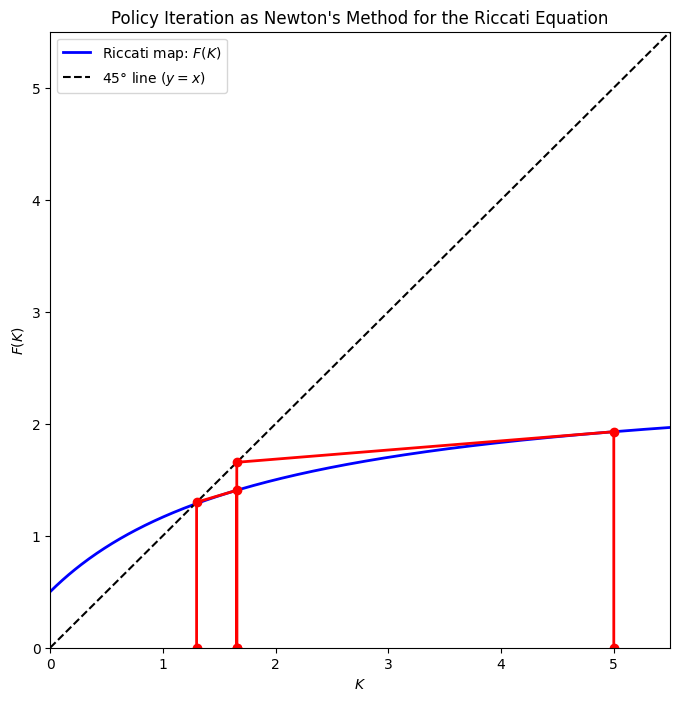

In [15]:
# ---------------------------------
# PI starting from K0
# ---------------------------------


def riccati_update_deriv(K):
    """
    Computes the derivative of F(K) with respect to K.

    Write F(K) in compact form as:
       F(K) = Q + α K - β K²/(R + δ K)
    with α = γA², β = (γAB)², δ = γB².
    Then:
       F'(K) = α - β*(2R*K + δ K²)/(R+δK)².
    """
    num = (gamma*A*B)**2
    return gamma*A**2 - num*(2*R*K + gamma*B**2*K**2) / (R + gamma*B**2*K)**2

# ---------------------------------
# Newton/Policy Iteration Update
# ---------------------------------
def newton_update(K):
    """
    Interprets policy iteration as Newton's method for solving F(K)=K.
    The tangent (linearization) of F at K is:
         L(K') = F(K) + F'(K)(K' - K)
    Setting L(K') = K' (i.e. y = x) and solving for K' gives:
         K' = K + (F(K) - K) / (1 - F'(K)).
    """
    F_val = riccati_update(K)
    F_deriv = riccati_update_deriv(K)
    return K + (F_val - K) / (1 - F_deriv)

# ---------------------------------
# Compute the Newton/Policy Iteration Sequence
# ---------------------------------
# Choose an initial guess for K. (Avoid zero if F'(0)=1.)
K0 = 5
num_iter = 2  # Number of policy (Newton) iterations

# Compute the sequence using the Newton update
newton_seq = [K0]
for i in range(num_iter):
    newton_seq.append(newton_update(newton_seq[-1]))

# ---------------------------------
# Build the Cobweb (Staircase) Points
# ---------------------------------
# We construct a cobweb diagram with the following moves:
# 1. Vertical move: from (K_i, 0) up to (K_i, F(K_i))
# 2. Diagonal move: along the tangent line from (K_i, F(K_i)) to its intersection with the 45° line at (K_{i+1}, K_{i+1})
# 3. Horizontal drop: from (K_{i+1}, K_{i+1}) back to the K–axis at (K_{i+1}, 0)
cobweb_points = []
for i in range(len(newton_seq)-1):
    # Vertical move: evaluation step
    cobweb_points.append((newton_seq[i], 0))
    cobweb_points.append((newton_seq[i], riccati_update(newton_seq[i])))
    # Diagonal (tangent) move: policy improvement step
    cobweb_points.append((newton_seq[i+1], newton_seq[i+1]))
    # Horizontal drop to the axis to mark the new starting point
    cobweb_points.append((newton_seq[i+1], 0))

# Separate the cobweb points into x and y coordinates
x_cob = [pt[0] for pt in cobweb_points]
y_cob = [pt[1] for pt in cobweb_points]

# ---------------------------------
# Prepare the Background Plot
# ---------------------------------
# Define a range for K that covers our iterates.
p_min = 0
p_max = max(newton_seq)*1.1
p_vals = np.linspace(p_min, p_max, 400)
f_vals = riccati_update(p_vals)

# Create the plot
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(p_vals, f_vals, 'b-', lw=2, label='Riccati map: $F(K)$')
ax.plot(p_vals, p_vals, 'k--', lw=1.5, label='45° line ($y=x$)')

ax.set_xlabel('$K$')
ax.set_ylabel('$F(K)$')
ax.set_title("Policy Iteration as Newton's Method for the Riccati Equation")
ax.legend()
ax.set_xlim(p_min, p_max)
ax.set_ylim(p_min, p_max)

# Prepare a line object for drawing the cobweb (staircase) construction:
cobweb_line, = ax.plot([], [], 'r-', lw=2, marker='o')

# ---------------------------------
# Animation Functions
# ---------------------------------
def init():
    """Initialize the cobweb line."""
    cobweb_line.set_data([], [])
    return cobweb_line,

def animate(i):
    """
    Update function for the animation.
    At frame i, extend the cobweb (staircase) using the points computed.
    """
    cobweb_line.set_data(x_cob[:i+1], y_cob[:i+1])
    return cobweb_line,

# Create the animation (one frame per cobweb point)
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=len(x_cob), interval=500, blit=True, repeat=False)

# ---------------------------------
# Save and Download the Animation as an MP4 file
# ---------------------------------
# Save the animation as an MP4 file (requires ffmpeg, which is pre-installed in Colab)
# anim.save('policy_iteration_animation.mp4', writer='ffmpeg', fps=2)

# Download the MP4 file
# files.download('policy_iteration_animation.mp4')

# ---------------------------------
# Display the Animation Inline (Optional)
# ---------------------------------

display(HTML(anim.to_html5_video()))